In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import re
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin

In [2]:
df_cleaned = pd.read_csv('Data/Clean_Dataset.csv')
df_cleaned.head()

,Unnamed: 0,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


In [3]:
df_cleaned.shape

(300153, 12)

In [4]:
df_business = pd.read_csv('Data/business.csv')
df_economy = pd.read_csv('Data/economy.csv')

In [5]:
df_business.head(1)

,date,airline,ch_code,num_code,dep_time,from,time_taken,stop,arr_time,to,price
0,11-02-2022,Air India,AI,868,18:00,Delhi,02h 00m,non-stop,20:00,Mumbai,"25,612"


In [6]:
df_economy.head(1)

,date,airline,ch_code,num_code,dep_time,from,time_taken,stop,arr_time,to,price
0,11-02-2022,SpiceJet,SG,8709,18:55,Delhi,02h 10m,non-stop,21:05,Mumbai,"5,953"


In [7]:
df_economy.shape

(206774, 11)

In [8]:
df_business.describe().T

,count,mean,std,min,25%,50%,75%,max
num_code,93487.0,780.056147,147.616038,401.0,706.0,820.0,874.0,996.0


In [9]:
df_business.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
date,93487,49,07-03-2022,2062,NaN,NaN,NaN,NaN,NaN,NaN,NaN
airline,93487,2,Vistara,60589,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ch_code,93487,2,UK,60589,NaN,NaN,NaN,NaN,NaN,NaN,NaN
num_code,93487.0,NaN,NaN,NaN,780.056147,147.616038,401.0,706.0,820.0,874.0,996.0
dep_time,93487,166,07:00,3805,NaN,NaN,NaN,NaN,NaN,NaN,NaN
from,93487,6,Mumbai,19858,NaN,NaN,NaN,NaN,NaN,NaN,NaN
time_taken,93487,373,02h 10m,1161,NaN,NaN,NaN,NaN,NaN,NaN,NaN
stop,93487,25,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,81489,NaN,NaN,NaN,NaN,NaN,NaN,NaN
arr_time,93487,176,19:55,4192,NaN,NaN,NaN,NaN,NaN,NaN,NaN
to,93487,6,Mumbai,18991,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
df_economy.describe(include = 'all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
date,206774,49,07-03-2022,4571,NaN,NaN,NaN,NaN,NaN,NaN,NaN
airline,206774,8,Vistara,67270,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ch_code,206774,8,UK,67270,NaN,NaN,NaN,NaN,NaN,NaN,NaN
num_code,206774.0,NaN,NaN,NaN,1706.096714,2320.463721,101.0,588.0,818.0,960.0,9991.0
dep_time,206774,251,07:00,4955,NaN,NaN,NaN,NaN,NaN,NaN,NaN
from,206774,6,Delhi,43029,NaN,NaN,NaN,NaN,NaN,NaN,NaN
time_taken,206774,483,02h 10m,3081,NaN,NaN,NaN,NaN,NaN,NaN,NaN
stop,206774,37,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,162114,NaN,NaN,NaN,NaN,NaN,NaN,NaN
arr_time,206774,266,19:55,5002,NaN,NaN,NaN,NaN,NaN,NaN,NaN
to,206774,6,Delhi,40654,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
df_economy['class'] = "Economy"
df_business['class'] = "Business"

In [12]:
pattern_strict_duration = r'^\d{2}h \d{2}m$'

def merge_frames(dfs):
    """dfs: list/tuple like [df_economy, df_business] -> single df"""
    df_economy, df_business = dfs
    return pd.concat([df_economy, df_business], ignore_index=True)

def clean_time_taken(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    # keep only strictly 'DDh DDm'
    df = df[df['time_taken'].astype(str).str.match(pattern_strict_duration, na=False)].copy()
    # to total minutes
    ext = df['time_taken'].str.extract(r'(?P<hours>\d{2})h (?P<minutes>\d{2})m').astype(int)
    df['duration'] = ext.eval('hours * 60 + minutes')
    # drop original
    df = df.drop(columns=['time_taken'])
    return df

def _clean_stop_value(value: str) -> str:
    # Remove tabs/newlines and collapse spaces
    value = re.sub(r'\s+', ' ', str(value).strip())
    # Remove anything after "Via ..."
    value = re.sub(r'\s+Via.*', '', value)
    # Preserve "non-stop" exactly
    if value.lower() == "non-stop":
        return "non-stop"
    # Else, normalize hyphen/plus spacing
    value = value.replace('-', ' ')
    value = re.sub(r'\+\s*', '+ ', value)
    return value.strip()

def clean_stop_col(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df['stops'] = df['stop'].apply(_clean_stop_value)
    df = df.drop(columns=['stop'])
    return df

def time_bucket_from_str_hhmm(time_str: str):
    if pd.isna(time_str):
        return None
    try:
        hour = int(str(time_str).split(':')[0])
    except Exception:
        return None
    if 4 <= hour < 8:
        return "Early Morning"
    elif 8 <= hour < 12:
        return "Morning"
    elif 12 <= hour < 16:
        return "Afternoon"
    elif 16 <= hour < 20:
        return "Evening"
    else:
        return "Night"

def add_time_buckets(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df['dep_time_bucket'] = df['dep_time'].apply(time_bucket_from_str_hhmm)
    df['arr_time_bucket'] = df['arr_time'].apply(time_bucket_from_str_hhmm)
    return df

def build_flight_number(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df['flight_number'] = df['ch_code'].astype(str).str.strip() + df['num_code'].astype(str).str.strip()
    df = df.drop(columns=['ch_code', 'num_code'])
    return df

def add_date_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    
    # Parse DD-MM-YYYY to datetime
    dt = pd.to_datetime(df['date'].astype(str).str.strip(), format='%d-%m-%Y', errors='coerce')
    
    # Day name and type
    df['day_name'] = dt.dt.day_name()
    df['day_type'] = np.where(df['day_name'].isin(['Saturday', 'Sunday']), 'Weekend', 'Weekday')
    
    # Calculate days until trip (reference date: 2022-02-10). Given within Kaggle notes.
    reference_date = pd.Timestamp("2022-02-10")
    df['days_until_trip'] = (dt - reference_date).dt.days

    # Ensure numeric (nullable integer so NaNs are permitted)
    df['days_until_trip'] = pd.to_numeric(df['days_until_trip'], errors='coerce').astype('Int64')
    
    # Drop raw date
    df = df.drop(columns=['date'])
    return df

def add_numeric_minutes(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    for col in ["dep_time", "arr_time"]:
        dt = pd.to_datetime(df[col].astype(str).str.strip(), format="%H:%M", errors="coerce")
        df[col.replace("_time", "_time_numeric")] = dt.dt.hour * 60 + dt.dt.minute
    return df

def clean_price(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df['price'] = (
        df['price']
        .astype(str)
        .str.replace(',', '', regex=False)
        .astype(float)
    )
    return df

# ---------- pipeline ----------
merge_and_clean_pipeline = Pipeline(steps=[
    ("merge",            FunctionTransformer(merge_frames, validate=False)),
    ("time_taken",       FunctionTransformer(clean_time_taken, validate=False)),
    ("stops",            FunctionTransformer(clean_stop_col, validate=False)),
    ("time_buckets",     FunctionTransformer(add_time_buckets, validate=False)),
    ("flight_number",    FunctionTransformer(build_flight_number, validate=False)),
    ("date_features",    FunctionTransformer(add_date_features, validate=False)),
    ("numeric_minutes",  FunctionTransformer(add_numeric_minutes, validate=False)),
    ("price_numeric",    FunctionTransformer(clean_price, validate=False)),
])


In [13]:
df_clean = merge_and_clean_pipeline.fit_transform([df_economy, df_business])
df_clean.head()

,airline,dep_time,from,arr_time,to,price,class,duration,stops,dep_time_bucket,arr_time_bucket,flight_number,day_name,day_type,days_until_trip,dep_time_numeric,arr_time_numeric
0,SpiceJet,18:55,Delhi,21:05,Mumbai,5953.0,Economy,130,non-stop,Evening,Night,SG8709,Friday,Weekday,1,1135,1265
1,SpiceJet,06:20,Delhi,08:40,Mumbai,5953.0,Economy,140,non-stop,Early Morning,Morning,SG8157,Friday,Weekday,1,380,520
2,AirAsia,04:25,Delhi,06:35,Mumbai,5956.0,Economy,130,non-stop,Early Morning,Early Morning,I5764,Friday,Weekday,1,265,395
3,Vistara,10:20,Delhi,12:35,Mumbai,5955.0,Economy,135,non-stop,Morning,Afternoon,UK995,Friday,Weekday,1,620,755
4,Vistara,08:50,Delhi,11:10,Mumbai,5955.0,Economy,140,non-stop,Morning,Morning,UK963,Friday,Weekday,1,530,670


In [14]:
print(df_clean['days_until_trip'].dtype)          # should show Int64
print(df_clean['days_until_trip'].notna().sum())  # must be > 0 to see a histogram
print(df_clean.select_dtypes(include='number').columns.tolist())

Int64
300216
['price', 'duration', 'days_until_trip', 'dep_time_numeric', 'arr_time_numeric']


In [15]:
def _ensure_dir(path):
    if path and not os.path.exists(path):
        os.makedirs(path, exist_ok=True)

def _slug(s: str):
    return re.sub(r'[^A-Za-z0-9_.-]+', '_', str(s)).strip('_')


# 1) Nulls & zeros summary ------------------------------------------------
class NullZeroSummary(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.summary_ = None

    def fit(self, X, y=None):
        df = X
        summary = pd.DataFrame(index=df.columns)
        summary['null_count'] = df.isnull().sum()
        summary['null_pct'] = (df.isnull().mean() * 100).round(3)

        numeric_cols = df.select_dtypes(include='number').columns
        zero_count = pd.Series(0, index=df.columns, dtype="int64")
        zero_pct = pd.Series(0.0, index=df.columns, dtype="float")

        if len(numeric_cols) > 0:
            zero_count.loc[numeric_cols] = df[numeric_cols].eq(0).sum().astype(int)
            zero_pct.loc[numeric_cols] = (df[numeric_cols].eq(0).mean() * 100).round(2)

        summary['zero_count'] = zero_count
        summary['zero_pct'] = zero_pct
        self.summary_ = summary.sort_values(by=['null_count', 'zero_count'], ascending=False)
        return self

    def transform(self, X):
        return X


# 2) Describe(all) --------------------------------------------------------
class DescribeAll(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.describe_ = None

    def fit(self, X, y=None):
        self.describe_ = X.describe(include='all').T
        return self

    def transform(self, X):
        return X


# 3) Plot categorical bars ------------------------------------------------
class PlotCategoricalBars(BaseEstimator, TransformerMixin):
    def __init__(self, top_n=10, color='cornflowerblue', cols=3,
                 save_plots=False, save_dir="eda_plots", save_individual=False,
                 save_prefix="cats", save_format="png", dpi=120):
        self.top_n = top_n
        self.color = color
        self.cols = cols
        self.save_plots = save_plots
        self.save_dir = save_dir
        self.save_individual = save_individual
        self.save_prefix = save_prefix
        self.save_format = save_format
        self.dpi = dpi
        self.saved_files_ = []

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        df = X
        cat_cols = df.select_dtypes(include=['object', 'category', 'bool']).columns
        n = len(cat_cols)
        if n == 0:
            print("No categorical columns to plot.")
            return X

        # combined grid
        rows = math.ceil(n / self.cols)
        fig, axes = plt.subplots(rows, self.cols, figsize=(self.cols * 8, rows * 6))
        axes = axes.flatten() if isinstance(axes, np.ndarray) else [axes]

        for i, col in enumerate(cat_cols):
            counts = df[col].value_counts(dropna=False).head(self.top_n)
            sns.barplot(x=counts.values, y=counts.index, color=self.color, ax=axes[i])
            axes[i].set_title(f'Top {min(self.top_n, len(counts))} in {col}')
            axes[i].set_xlabel('Count')
            axes[i].set_ylabel(col)

            # optional individual save
            if self.save_plots and self.save_individual:
                _ensure_dir(self.save_dir)
                fpath = os.path.join(self.save_dir, f"{self.save_prefix}_{_slug(col)}.{self.save_format}")
                plt.figure(figsize=(8, 6))
                sns.barplot(x=counts.values, y=counts.index, color=self.color)
                plt.title(f'Top {min(self.top_n, len(counts))} in {col}')
                plt.xlabel('Count'); plt.ylabel(col); plt.tight_layout()
                plt.savefig(fpath, dpi=self.dpi)
                plt.close()
                self.saved_files_.append(fpath)

        # remove unused panels
        for j in range(i + 1, len(axes)):
            fig.delaxes(axes[j])

        fig.tight_layout()
        plt.show()

        if self.save_plots:
            _ensure_dir(self.save_dir)
            grid_path = os.path.join(self.save_dir, f"{self.save_prefix}_combined.{self.save_format}")
            fig.savefig(grid_path, dpi=self.dpi)
            self.saved_files_.append(grid_path)
        plt.close(fig)
        return X


# 4) Plot numeric histograms ---------------------------------------------
class PlotNumericalHists(BaseEstimator, TransformerMixin):
    def __init__(self, bins=30, kde=True, color='skyblue', cols=3,
                 save_plots=False, save_dir="eda_plots", save_individual=False,
                 save_prefix="nums", save_format="png", dpi=120):
        self.bins = bins
        self.kde = kde
        self.color = color
        self.cols = cols
        self.save_plots = save_plots
        self.save_dir = save_dir
        self.save_individual = save_individual
        self.save_prefix = save_prefix
        self.save_format = save_format
        self.dpi = dpi
        self.saved_files_ = []

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        df = X
        numeric_cols = df.select_dtypes(include='number').columns
        n = len(numeric_cols)
        if n == 0:
            print("No numeric columns to plot.")
            return X

        # combined grid
        rows = math.ceil(n / self.cols)
        fig, axes = plt.subplots(rows, self.cols, figsize=(self.cols * 8, rows * 8))
        axes = axes.flatten() if isinstance(axes, np.ndarray) else [axes]

        for i, col in enumerate(numeric_cols):
            sns.histplot(df[col].dropna(), bins=self.bins, kde=self.kde, color=self.color, ax=axes[i])
            axes[i].set_title(f'Histogram of {col}')
            axes[i].set_xlabel(col); axes[i].set_ylabel('Frequency')

            # optional individual save
            if self.save_plots and self.save_individual:
                _ensure_dir(self.save_dir)
                fpath = os.path.join(self.save_dir, f"{self.save_prefix}_{_slug(col)}.{self.save_format}")
                plt.figure(figsize=(8, 6))
                sns.histplot(df[col].dropna(), bins=self.bins, kde=self.kde, color=self.color)
                plt.title(f'Histogram of {col}')
                plt.xlabel(col); plt.ylabel('Frequency'); plt.tight_layout()
                plt.savefig(fpath, dpi=self.dpi)
                plt.close()
                self.saved_files_.append(fpath)

        # remove unused panels
        for j in range(i + 1, len(axes)):
            fig.delaxes(axes[j])

        fig.tight_layout()
        plt.show()

        if self.save_plots:
            _ensure_dir(self.save_dir)
            grid_path = os.path.join(self.save_dir, f"{self.save_prefix}_combined.{self.save_format}")
            fig.savefig(grid_path, dpi=self.dpi)
            self.saved_files_.append(grid_path)
        plt.close(fig)
        return X


# 5) Correlation heatmap --------------------------------------------------
class PlotCorrHeatmap(BaseEstimator, TransformerMixin):
    def __init__(self, annot=True, fmt=".2f",
                 save_plots=False, save_dir="eda_plots",
                 save_prefix="corr", save_format="png", dpi=120):
        self.annot = annot
        self.fmt = fmt
        self.save_plots = save_plots
        self.save_dir = save_dir
        self.save_prefix = save_prefix
        self.save_format = save_format
        self.dpi = dpi
        self.saved_files_ = []

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        num_df = X.select_dtypes(include='number')
        if num_df.shape[1] == 0:
            print("No numeric columns for correlation heatmap.")
            return X

        plt.figure(figsize=(min(1.5 * num_df.shape[1], 22), min(1.2 * num_df.shape[1], 18)))
        ax = sns.heatmap(num_df.corr(numeric_only=True), annot=self.annot, fmt=self.fmt)
        plt.title("Correlation Heatmap (numeric features)")
        plt.tight_layout()
        plt.show()

        if self.save_plots:
            _ensure_dir(self.save_dir)
            fpath = os.path.join(self.save_dir, f"{self.save_prefix}.{self.save_format}")
            ax.get_figure().savefig(fpath, dpi=self.dpi)
            plt.close(ax.get_figure())
            self.saved_files_.append(fpath)
        return X


# -------------------- Build the scikit-learn pipeline --------------------
EDA_Pipeline = Pipeline(steps=[
    ("null_zero_summary", NullZeroSummary()),
    ("describe_all",      DescribeAll()),
    ("plot_cats",         PlotCategoricalBars(top_n=10, save_plots=True, save_individual=True,
                                              save_dir="eda_plots", save_prefix="cats")),
    ("plot_nums",         PlotNumericalHists(bins=30, kde=True, save_plots=True, save_individual=True,
                                             save_dir="eda_plots", save_prefix="nums")),
    ("corr_heatmap",      PlotCorrHeatmap(annot=True, fmt=".2f", save_plots=True,
                                          save_dir="eda_plots", save_prefix="corr")),
])

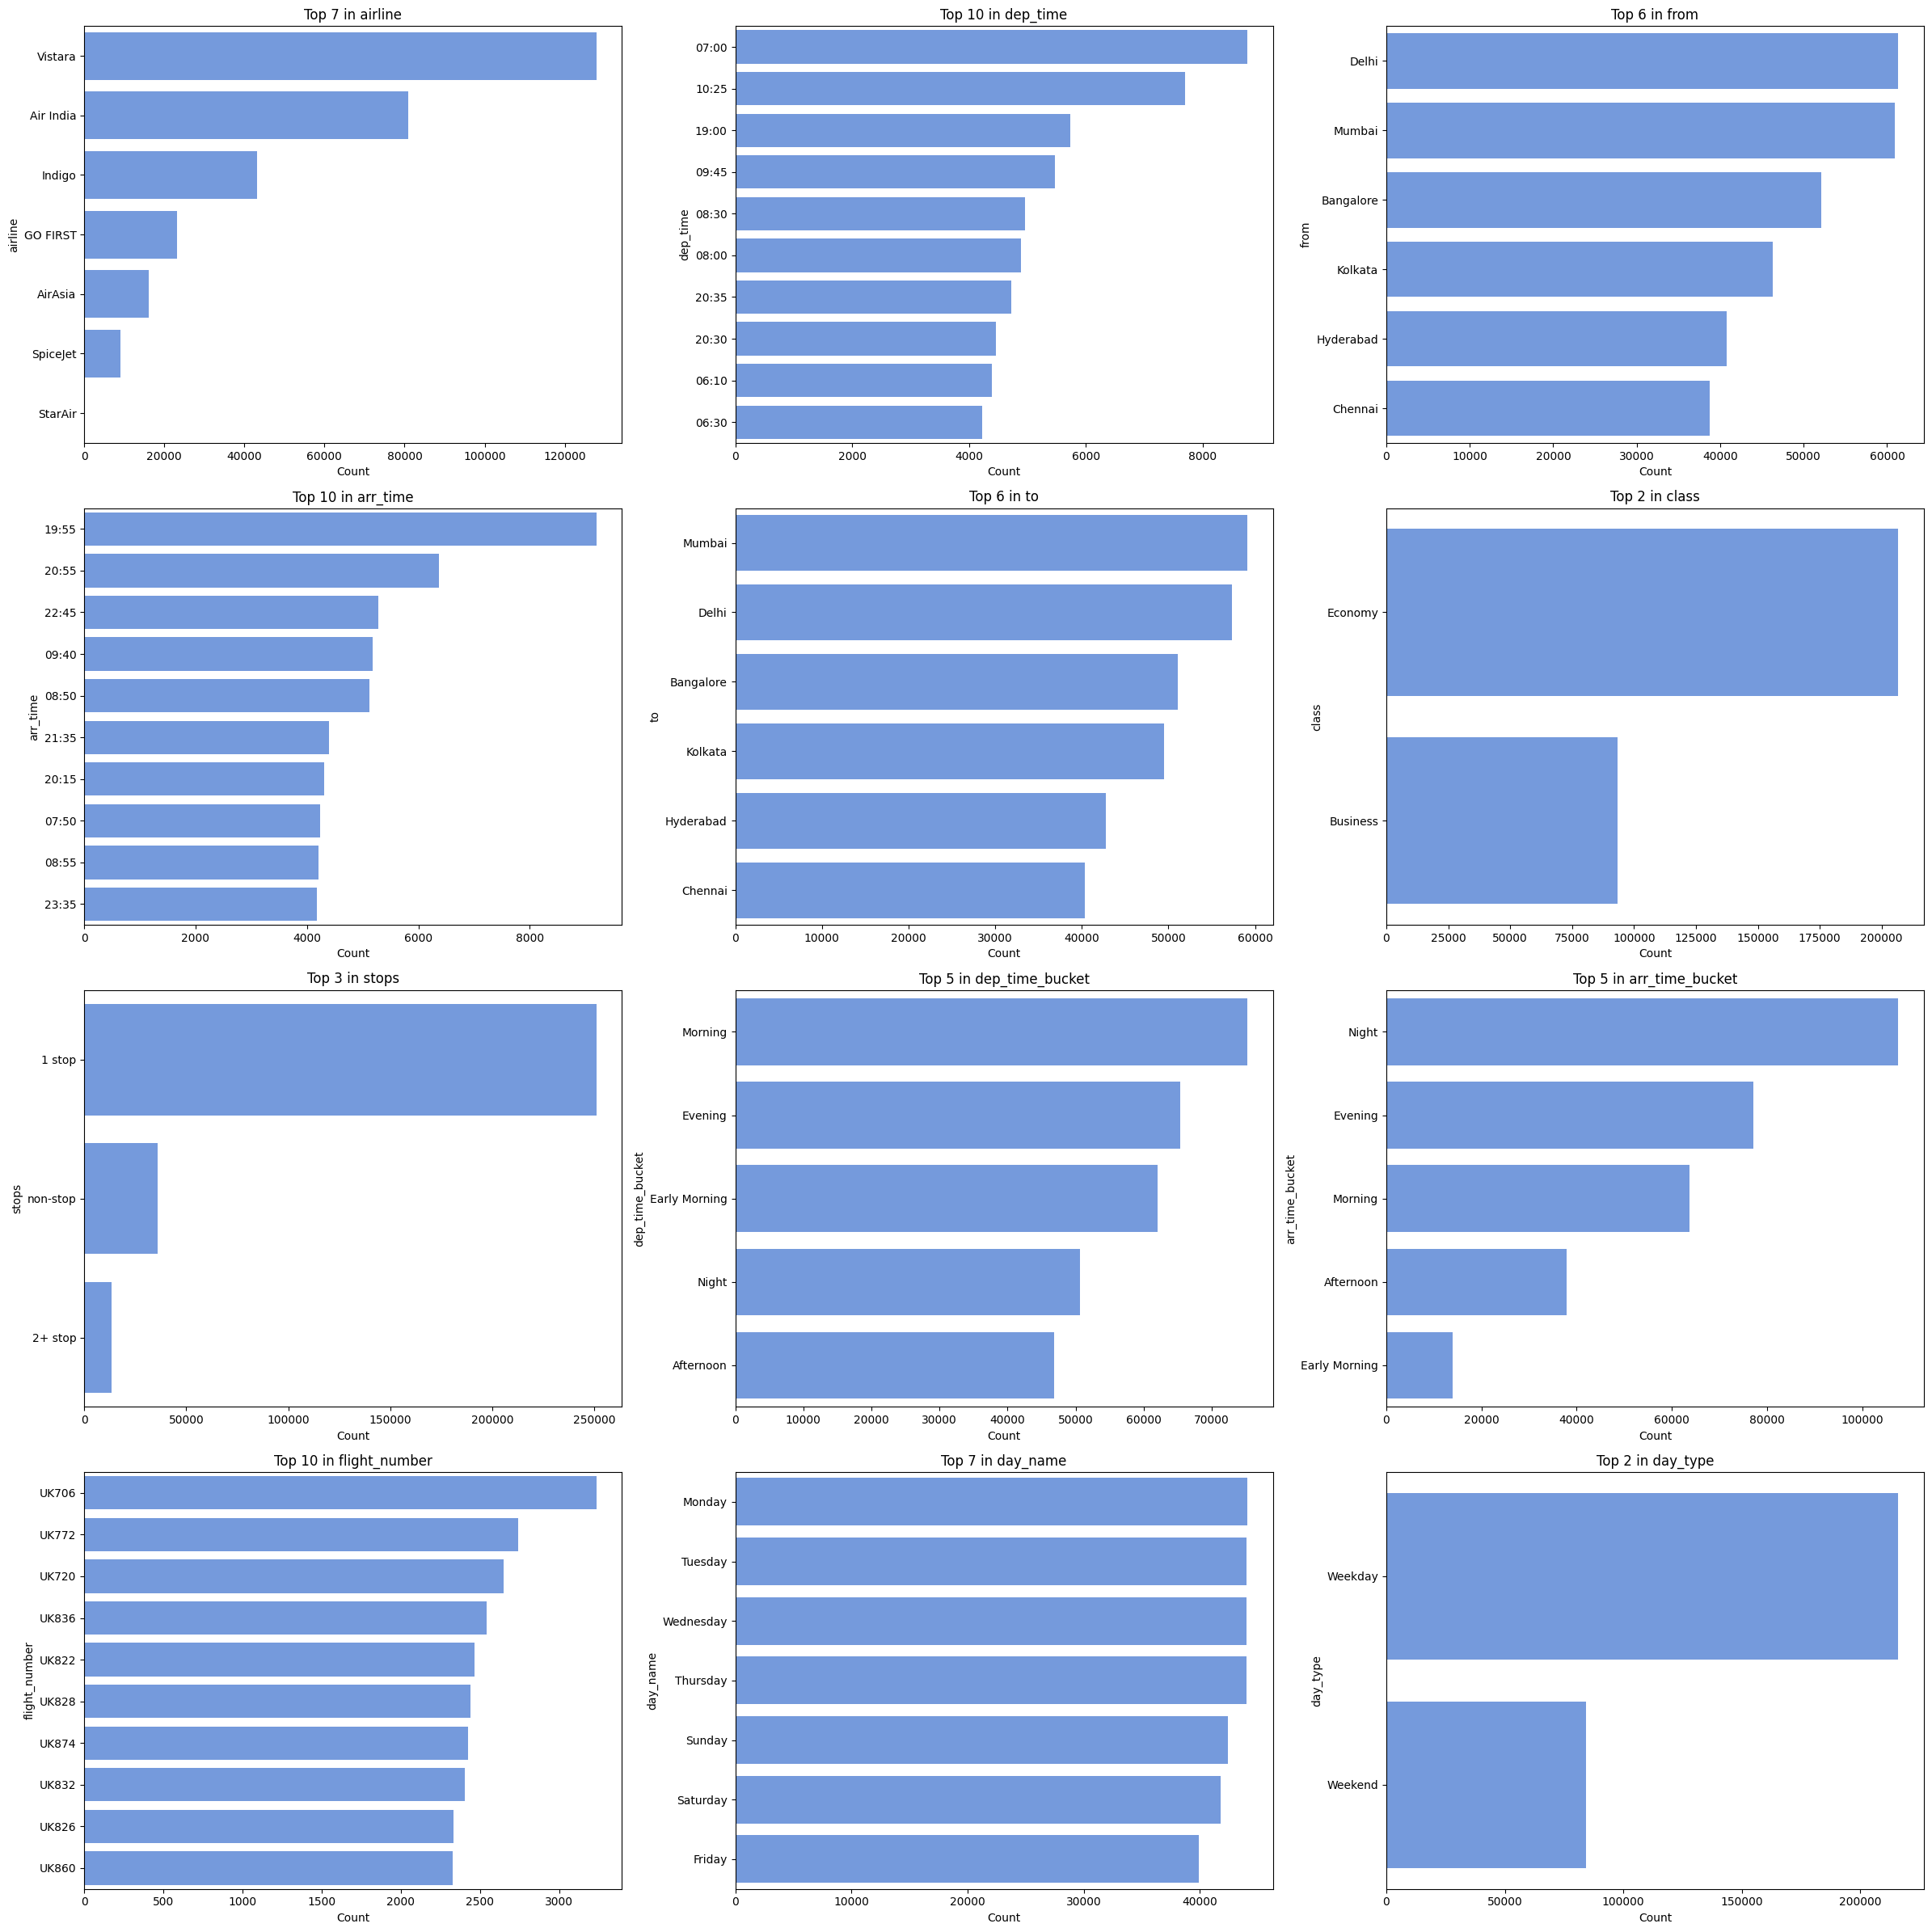

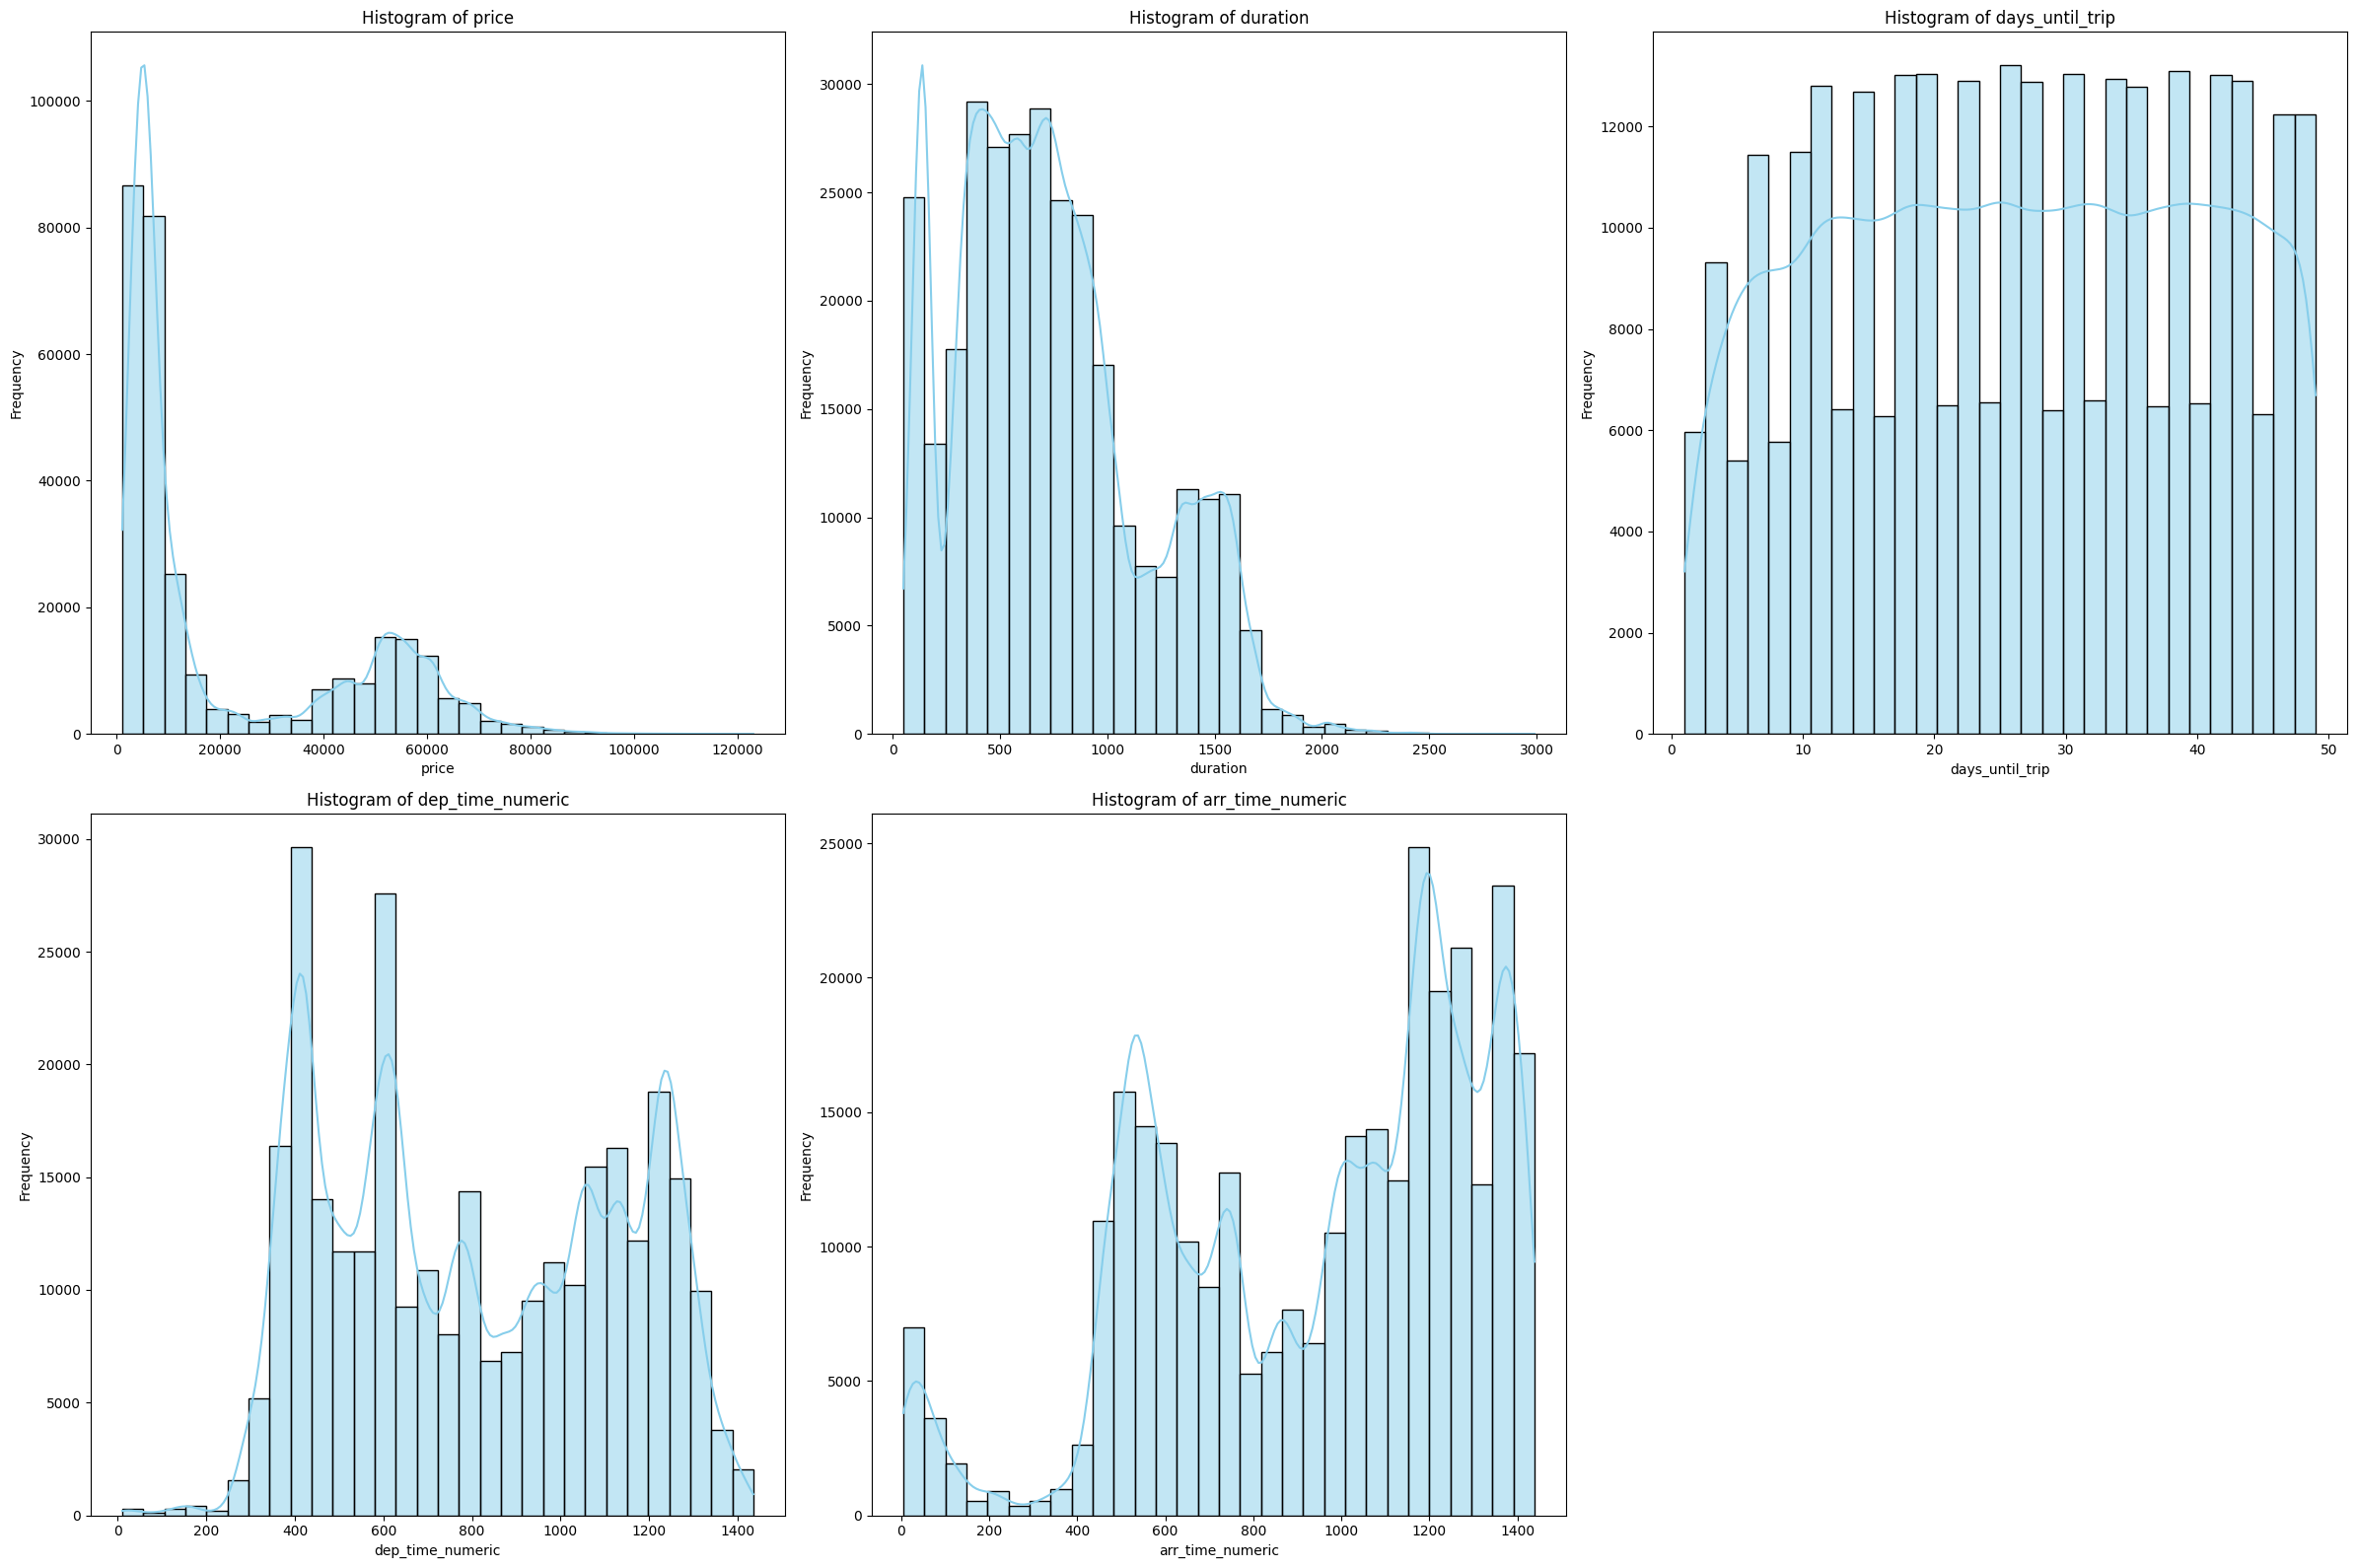

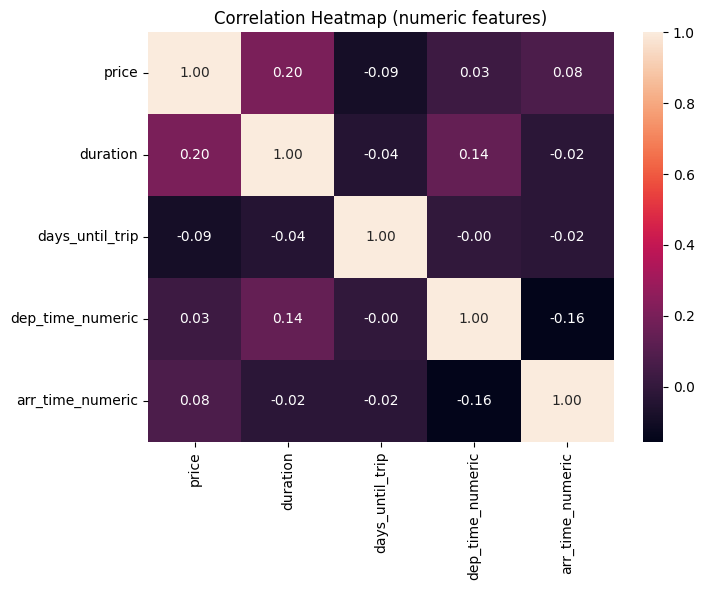

In [16]:
# Run EDA (plots render and also save)
_ = EDA_Pipeline.fit_transform(df_clean)

cats_files = EDA_Pipeline.named_steps["plot_cats"].saved_files_
nums_files = EDA_Pipeline.named_steps["plot_nums"].saved_files_
corr_files = EDA_Pipeline.named_steps["corr_heatmap"].saved_files_

# Summaries:
null_zero = EDA_Pipeline.named_steps["null_zero_summary"].summary_
desc_all  = EDA_Pipeline.named_steps["describe_all"].describe_

In [17]:
null_zero

,null_count,null_pct,zero_count,zero_pct
airline,0,0.0,0,0.0
dep_time,0,0.0,0,0.0
from,0,0.0,0,0.0
arr_time,0,0.0,0,0.0
to,0,0.0,0,0.0
price,0,0.0,0,0.0
class,0,0.0,0,0.0
duration,0,0.0,0,0.0
stops,0,0.0,0,0.0
dep_time_bucket,0,0.0,0,0.0


In [18]:
desc_all

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
airline,300216,7,Vistara,127859,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dep_time,300216,251,07:00,8760,NaN,NaN,NaN,NaN,NaN,NaN,NaN
from,300216,6,Delhi,61345,NaN,NaN,NaN,NaN,NaN,NaN,NaN
arr_time,300216,266,19:55,9194,NaN,NaN,NaN,NaN,NaN,NaN,NaN
to,300216,6,Mumbai,59099,NaN,NaN,NaN,NaN,NaN,NaN,NaN
price,300216.0,NaN,NaN,NaN,20886.335495,22696.60343,1105.0,4783.0,7425.0,42521.0,123071.0
class,300216,2,Economy,206729,NaN,NaN,NaN,NaN,NaN,NaN,NaN
duration,300216.0,NaN,NaN,NaN,733.142804,431.559663,50.0,410.0,675.0,970.0,2990.0
stops,300216,3,1 stop,250886,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dep_time_bucket,300216,5,Morning,75211,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
df_clean.head()

,airline,dep_time,from,arr_time,to,price,class,duration,stops,dep_time_bucket,arr_time_bucket,flight_number,day_name,day_type,days_until_trip,dep_time_numeric,arr_time_numeric
0,SpiceJet,18:55,Delhi,21:05,Mumbai,5953.0,Economy,130,non-stop,Evening,Night,SG8709,Friday,Weekday,1,1135,1265
1,SpiceJet,06:20,Delhi,08:40,Mumbai,5953.0,Economy,140,non-stop,Early Morning,Morning,SG8157,Friday,Weekday,1,380,520
2,AirAsia,04:25,Delhi,06:35,Mumbai,5956.0,Economy,130,non-stop,Early Morning,Early Morning,I5764,Friday,Weekday,1,265,395
3,Vistara,10:20,Delhi,12:35,Mumbai,5955.0,Economy,135,non-stop,Morning,Afternoon,UK995,Friday,Weekday,1,620,755
4,Vistara,08:50,Delhi,11:10,Mumbai,5955.0,Economy,140,non-stop,Morning,Morning,UK963,Friday,Weekday,1,530,670


In [20]:
df_clean.to_csv('Data/df_pipeline_cleaned', index = False)

In [28]:
# Separate features and target
X = df_clean.drop(columns=['price'])
y = df_clean['price']

# Stratified split based on days_left
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,        # seed for reproducibility
    # ensures even representation of time series component
    stratify=X['days_until_trip'] 
)

# Combine back into train/test DataFrames if needed
train_df = X_train.copy()
train_df['price'] = y_train

test_df = X_test.copy()
test_df['price'] = y_test

In [29]:
X_test.columns

Index(['airline', 'dep_time', 'from', 'arr_time', 'to', 'class', 'duration',
       'stops', 'dep_time_bucket', 'arr_time_bucket', 'flight_number',
       'day_name', 'day_type', 'days_until_trip', 'dep_time_numeric',
       'arr_time_numeric'],
      dtype='object')

In [30]:
# Drop unused features for getting predictions from batch
X_train = X_train.drop(['flight_number', 'arr_time_numeric', 'dep_time_numeric', 'dep_time', 'arr_time'], axis = 1)
X_test = X_test.drop(['flight_number', 'arr_time_numeric', 'dep_time_numeric', 'dep_time', 'arr_time'], axis = 1)

In [31]:
X_test.to_csv('Data/df_pipeline_cleaned_X_test', index = False)